# Machine Learning Report 3 Notebook 2

Import the necessary files

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.mixture
import sklearn.metrics
import sklearn.decomposition
import sklearn.random_projection
import sklearn.discriminant_analysis
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import time
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

In [3]:
df1 = pd.read_csv('googleplaystore.csv')
df1.head(10)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up


In [4]:
store = df1
store.Size = store.Size.replace("Varies with device",np.nan)
store.Size = store.Size.str.replace("M","000")
store.Size = store.Size.str.replace("k","")
#store.Size = store.Size.apply(lambda x: float(x.replace("k",""))/1000 if "k" in x else x)
#ı wanted use this but ı get error so ı added "000" to Megabyte

store.Size = store.Size.replace("1,000+",1000)

store.Installs = store.Installs.str.replace(",","")
store.Installs = store.Installs.apply(lambda x: x.strip("+"))
store.Installs = store.Installs.replace("Free",np.nan)

store.Price = store.Price.str.replace("$","")

store = store.drop(store.index[10472])
poss_types = list(set(store.Category))
poss_genres = list(set(store.Genres))
print poss_types
print poss_genres

store[["Size","Installs","Reviews","Price"]] = store[["Size","Installs","Reviews","Price"]].astype("float")
store = store.dropna()

['LIBRARIES_AND_DEMO', 'AUTO_AND_VEHICLES', 'BUSINESS', 'ENTERTAINMENT', 'MEDICAL', 'MAPS_AND_NAVIGATION', 'LIFESTYLE', 'GAME', 'BOOKS_AND_REFERENCE', 'SHOPPING', 'HOUSE_AND_HOME', 'FAMILY', 'COMICS', 'PHOTOGRAPHY', 'PARENTING', 'WEATHER', 'ART_AND_DESIGN', 'PERSONALIZATION', 'DATING', 'EVENTS', 'BEAUTY', 'HEALTH_AND_FITNESS', 'VIDEO_PLAYERS', 'FINANCE', 'PRODUCTIVITY', 'COMMUNICATION', 'TRAVEL_AND_LOCAL', 'SPORTS', 'SOCIAL', 'EDUCATION', 'TOOLS', 'NEWS_AND_MAGAZINES', 'FOOD_AND_DRINK']
['Parenting;Music & Video', 'Communication;Creativity', 'Food & Drink', 'Music;Music & Video', 'Lifestyle;Pretend Play', 'Art & Design;Pretend Play', 'Books & Reference;Creativity', 'Board;Brain Games', 'Business', 'Adventure;Action & Adventure', 'Photography', 'Simulation;Action & Adventure', 'Education;Music & Video', 'Educational;Creativity', 'Puzzle;Brain Games', 'Parenting;Brain Games', 'Casual;Brain Games', 'Simulation', 'Educational;Pretend Play', 'Social', 'Card;Action & Adventure', 'Entertainme

In [5]:
store.describe()

,Rating,Reviews,Size,Installs,Price
count,7723.000000,7.723000e+03,7723.000000,7.723000e+03,7723.000000
mean,4.173935,2.948983e+05,21104.397061,8.424070e+06,1.128169
std,0.544638,1.863933e+06,24912.454999,5.015742e+07,17.408036
min,1.000000,1.000000e+00,1.000000,1.000000e+00,0.000000
25%,4.000000,1.075000e+02,6.100000,1.000000e+04,0.000000
50%,4.300000,2.332000e+03,14000.000000,1.000000e+05,0.000000
75%,4.500000,3.905300e+04,33000.000000,1.000000e+06,0.000000
max,5.000000,4.489389e+07,100000.000000,1.000000e+09,400.000000


In [6]:
cluster_data = store[["Size","Installs","Reviews","Price","Rating"]]
cluster_data['Installs'] = np.log10(cluster_data['Installs'])
cluster_data_normalized = (cluster_data-cluster_data.min())/(cluster_data.max()-cluster_data.min())
cluster_data_normalized.describe()


/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Size,Installs,Reviews,Price,Rating
count,7723.000000,7723.000000,7723.000000,7723.00000,7723.000000
mean,0.211036,0.562201,0.006569,0.00282,0.793484
std,0.249127,0.178700,0.041519,0.04352,0.136160
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000051,0.444444,0.000002,0.00000,0.750000
50%,0.139991,0.555556,0.000052,0.00000,0.825000
75%,0.329993,0.666667,0.000870,0.00000,0.875000
max,1.000000,1.000000,1.000000,1.00000,1.000000


In [7]:
cluster_data_extended = cluster_data_normalized.copy()
#print store.Category.tolist()
#print poss_types
for i in poss_types:
    t = []
    for j in store.Category.tolist():
        if i == j:
            t.append(1)
        else:
            t.append(0)
    cluster_data_extended[i+'_YN'] = t
cluster_data_extended.head(10)

,Size,Installs,Reviews,Price,Rating,LIBRARIES_AND_DEMO_YN,AUTO_AND_VEHICLES_YN,BUSINESS_YN,ENTERTAINMENT_YN,MEDICAL_YN,...,FINANCE_YN,PRODUCTIVITY_YN,COMMUNICATION_YN,TRAVEL_AND_LOCAL_YN,SPORTS_YN,SOCIAL_YN,EDUCATION_YN,TOOLS_YN,NEWS_AND_MAGAZINES_YN,FOOD_AND_DRINK_YN
0,0.189992,0.444444,0.000004,0.0,0.775,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.139991,0.633219,0.000022,0.0,0.725,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000077,0.744330,0.001949,0.0,0.925,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.249992,0.855441,0.004803,0.0,0.875,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000018,0.555556,0.000022,0.0,0.825,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.000046,0.522108,0.000004,0.0,0.850,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.189992,0.522108,0.000004,0.0,0.700,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.289993,0.666667,0.000820,0.0,0.775,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.329993,0.666667,0.000307,0.0,0.850,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0.000021,0.444444,0.000003,0.0,0.925,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/anaconda3/envs/python2/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


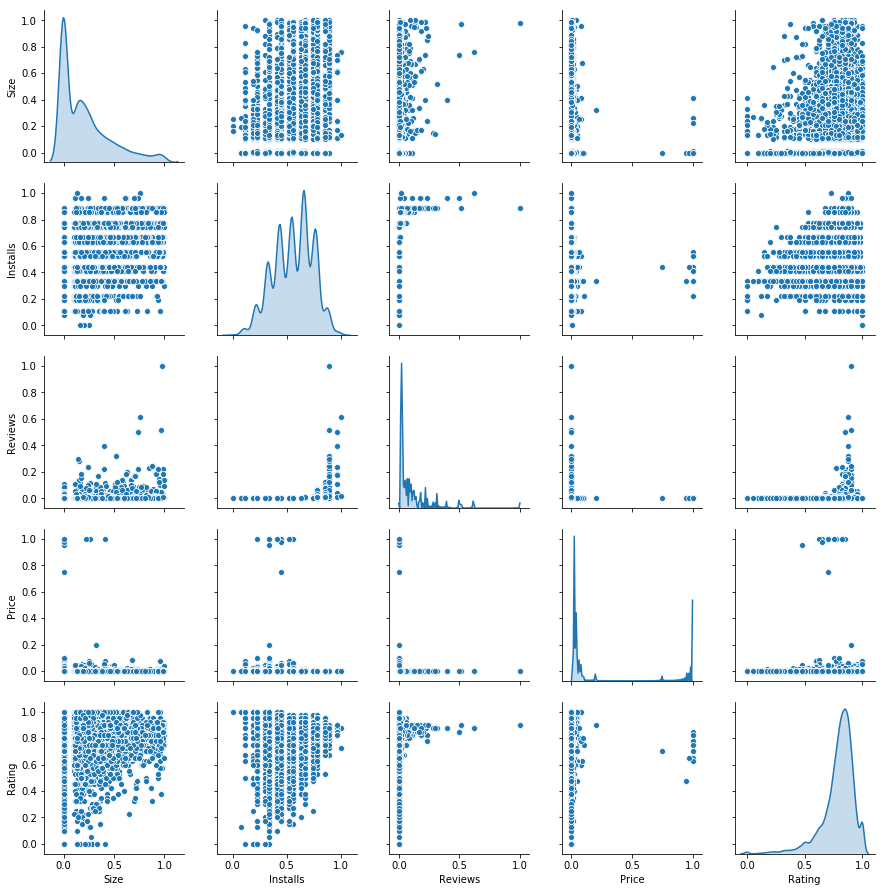

In [7]:
# Create the default pairplot
sns.pairplot(cluster_data_normalized, diag_kind="kde")

### Task 1.1: K-Means Clustering

Well, the good news is that now all our data appears to be fully parsed. The bad news is that it looks pretty crappy. There are no obvious trends or patterns, just blobs that are somewhat separated due to the discretization of data in the columns of the rating system, the prices, and the install sizes. Normalization didn't really do us any big favors either, but it was a necessary evil when tackling the numbers given for the installations. We will try doing some k-means on this data, but my hopes aren't high...

In [126]:
silhouettes_norm_kmeans = []
for i in range(2,11):
    kmeans = sklearn.cluster.KMeans(n_clusters=i).fit(cluster_data_normalized)
#    print kmeans.cluster_centers_
    silhouettes_norm_kmeans.append(sklearn.metrics.silhouette_score(cluster_data_normalized, kmeans.labels_))
#print silhouettes

[0.1150012341591533, 0.09218727660888441, 0.12383660361155821, 0.12557042861875226, 0.21525193402977696, 0.191158322188654, 0.2591425244625757, 0.26466348563236525, 0.2823253853671403]


In [127]:
silhouettes_ext_kmeans = []
for i in range(2,11):
    kmeans = sklearn.cluster.KMeans(n_clusters=i).fit(cluster_data_extended)
#    print kmeans.cluster_centers_
    silhouettes_ext_kmeans.append(sklearn.metrics.silhouette_score(cluster_data_extended, kmeans.labels_))
#print silhouettes

[0.1150012341591533, 0.09218727660888441, 0.12383660361155821, 0.12557042861875226, 0.21525193402977696, 0.191158322188654, 0.2591425244625757, 0.26466348563236525, 0.2823253853671403]


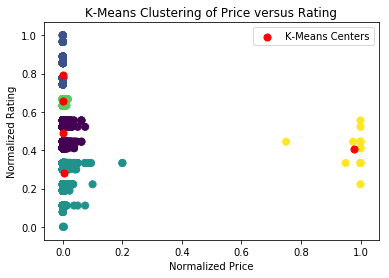

In [141]:
price_installs = cluster_data_normalized[['Price','Installs']]
kmeans = sklearn.cluster.KMeans(n_clusters=5).fit(price_installs)
cluster_centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(np.array(price_installs)[:, 0],\
            np.array(price_installs)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='K-Means Centers')
plt.xlabel('Normalized Price')
plt.ylabel('Normalized Rating')
plt.legend()
plt.title('K-Means Clustering of Price versus Rating')
plt.show()

### Task 1.2: Expectation Maximization

In [9]:
exp_max = sklearn.mixture.GaussianMixture(n_components=2,init_params='random',max_iter=1000)
r = exp_max.fit(cluster_data_normalized)
print r.means_

[[3.59741878e-01 6.75581553e-01 4.71379843e-02 2.16295783e-02
  8.38082234e-01]
 [1.89527548e-01 5.45801953e-01 7.00904700e-04 9.99011604e-05
  7.87033107e-01]]


In [128]:
silhouettes_norm_em = []
for i in range(2,11):
    exp_max = sklearn.mixture.GaussianMixture(n_components=i,init_params='random',\
                                             max_iter=1000).fit(cluster_data_normalized)
#    print kmeans.cluster_centers_
    silhouettes_norm_em.append(sklearn.metrics.silhouette_score(cluster_data_normalized, \
                                                        exp_max.predict(cluster_data_normalized)))
#print silhouettes

In [129]:
silhouettes_ext_em = []
for i in range(2,11):
    exp_max = sklearn.mixture.GaussianMixture(n_components=i,init_params='random',\
                                             max_iter=1000).fit(cluster_data_extended)
#    print kmeans.cluster_centers_
    silhouettes_ext_em.append(sklearn.metrics.silhouette_score(cluster_data_extended, \
                                                        exp_max.predict(cluster_data_extended)))
#print silhouettes

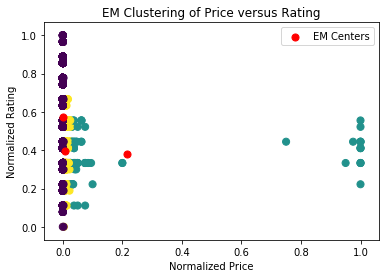

In [140]:
price_installs = cluster_data_normalized[['Price','Installs']]
exp_max = sklearn.mixture.GaussianMixture(n_components=3, init_params='random',max_iter=1000)
r = exp_max.fit(price_installs)
cluster_centers = r.means_
plt.figure()
plt.scatter(np.array(price_installs)[:, 0],\
            np.array(price_installs)[:, 1], c=r.predict(price_installs), s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='EM Centers')
plt.xlabel('Normalized Price')
plt.ylabel('Normalized Rating')
plt.title('EM Clustering of Price versus Rating')
plt.legend()
plt.show()

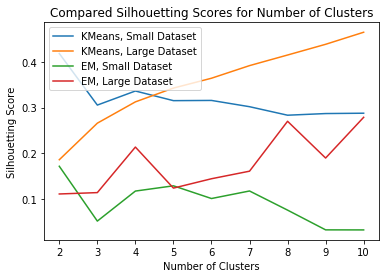

In [145]:
plt.figure()
plt.plot(range(2,11),silhouettes_norm_kmeans,label='KMeans, Small Dataset')
plt.plot(range(2,11),silhouettes_ext_kmeans,label='KMeans, Large Dataset')
plt.plot(range(2,11),silhouettes_norm_em,label='EM, Small Dataset')
plt.plot(range(2,11),silhouettes_ext_em,label='EM, Large Dataset')
plt.legend()
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouetting Score')
plt.title('Compared Silhouetting Scores for Number of Clusters')
plt.show()

### Task 1.3: Principal Component Analysis (PCA)

In [8]:
PCA = sklearn.decomposition.PCA(n_components=2)
PCA.fit(cluster_data_normalized)
PCA_fit_transform = PCA.fit_transform(cluster_data_normalized)

In [9]:
PCA = sklearn.decomposition.PCA(n_components=2)
PCA.fit(cluster_data_extended)
PCA_fit_transform_ext = PCA.fit_transform(cluster_data_extended)

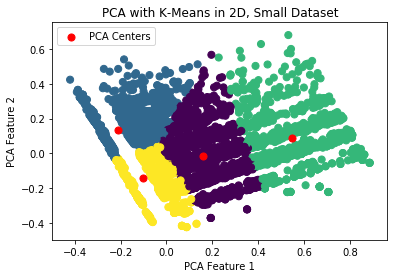

In [10]:
kmeans = sklearn.cluster.KMeans(n_clusters=4).fit(PCA_fit_transform)
cluster_centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(np.array(PCA_fit_transform)[:, 0],\
            np.array(PCA_fit_transform)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='PCA Centers')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA with K-Means in 2D, Small Dataset')
plt.legend()
plt.show()


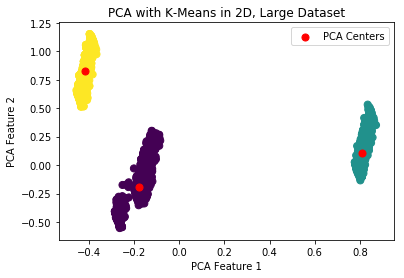

In [11]:
kmeans = sklearn.cluster.KMeans(n_clusters=3).fit(PCA_fit_transform_ext)
cluster_centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(np.array(PCA_fit_transform_ext)[:, 0],\
            np.array(PCA_fit_transform_ext)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='PCA Centers')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.title('PCA with K-Means in 2D, Large Dataset')
plt.legend()
plt.show()


### Task 1.4: Independent Component Analysis (ICA)

In [12]:
ICA = sklearn.decomposition.FastICA(n_components=2)
ICA.fit(cluster_data_normalized)
ICA_fit_transform = ICA.fit_transform(cluster_data_normalized)

In [13]:
ICA = sklearn.decomposition.FastICA(n_components=2)
ICA.fit(cluster_data_extended)
ICA_fit_transform_ext = ICA.fit_transform(cluster_data_extended)

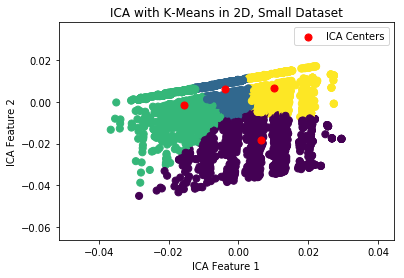

In [14]:
kmeans = sklearn.cluster.KMeans(n_clusters=4).fit(ICA_fit_transform)
cluster_centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(np.array(ICA_fit_transform)[:, 0], \
            np.array(ICA_fit_transform)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='ICA Centers')
plt.xlabel('ICA Feature 1')
plt.ylabel('ICA Feature 2')
plt.title('ICA with K-Means in 2D, Small Dataset')
plt.legend()
plt.show()

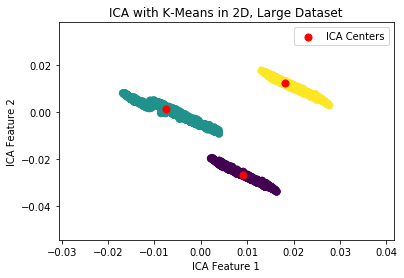

In [16]:
kmeans_ICA = sklearn.cluster.KMeans(n_clusters=3).fit(ICA_fit_transform_ext)
cluster_centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(np.array(ICA_fit_transform_ext)[:, 0], \
            np.array(ICA_fit_transform_ext)[:, 1], c=kmeans_ICA.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='ICA Centers')
plt.xlabel('ICA Feature 1')
plt.ylabel('ICA Feature 2')
plt.title('ICA with K-Means in 2D, Large Dataset')
plt.legend()
plt.show()

### Task 1.5: Randomized Component Analysis (RCA)

In [83]:
RCA = sklearn.random_projection.GaussianRandomProjection(2)
RCA.fit(cluster_data_normalized)
RCA_fit_transform = RCA.fit_transform(cluster_data_normalized)

In [84]:
RCA = sklearn.random_projection.GaussianRandomProjection(2)
RCA.fit(cluster_data_extended)
RCA_fit_transform_ext = RCA.fit_transform(cluster_data_extended)

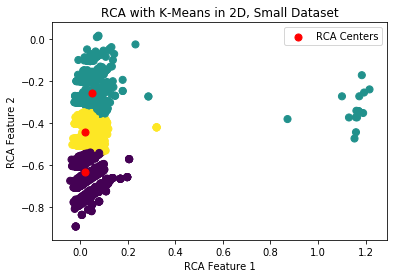

In [90]:
kmeans = sklearn.cluster.KMeans(n_clusters=3).fit(RCA_fit_transform)
cluster_centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(np.array(RCA_fit_transform)[:, 0], \
            np.array(RCA_fit_transform)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='RCA Centers')
plt.xlabel('RCA Feature 1')
plt.ylabel('RCA Feature 2')
plt.title('RCA with K-Means in 2D, Small Dataset')
plt.legend()
plt.show()


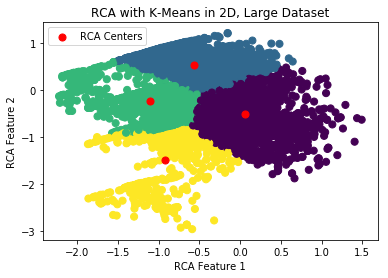

In [91]:
kmeans = sklearn.cluster.KMeans(n_clusters=4).fit(RCA_fit_transform_ext)
cluster_centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(np.array(RCA_fit_transform_ext)[:, 0], \
            np.array(RCA_fit_transform_ext)[:, 1], c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='RCA Centers')
plt.xlabel('RCA Feature 1')
plt.ylabel('RCA Feature 2')
plt.title('RCA with K-Means in 2D, Large Dataset')
plt.legend()
plt.show()


### Task 1.6: t-Distributed Stochastic Neighbor Embedding (t-SNE)

In [21]:
TSNE = sklearn.manifold.TSNE(2,perplexity=5)
TSNE.fit(cluster_data_normalized)
TSNE_fit_transform_5 = TSNE.fit_transform(cluster_data_normalized)

In [22]:
TSNE = sklearn.manifold.TSNE(2,perplexity=5)
TSNE.fit(cluster_data_extended)
TSNE_fit_transform_ext_5 = TSNE.fit_transform(cluster_data_extended)

In [23]:
TSNE = sklearn.manifold.TSNE(2,perplexity=15)
TSNE.fit(cluster_data_normalized)
TSNE_fit_transform_15 = TSNE.fit_transform(cluster_data_normalized)

In [24]:
TSNE = sklearn.manifold.TSNE(2,perplexity=15)
TSNE.fit(cluster_data_extended)
TSNE_fit_transform_ext_15 = TSNE.fit_transform(cluster_data_extended)

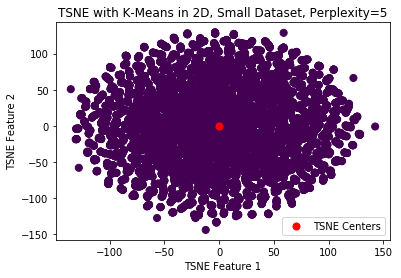

In [146]:
kmeans = sklearn.cluster.KMeans(n_clusters=1).fit(TSNE_fit_transform_5)
cluster_centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(np.array(TSNE_fit_transform_5)[:, 0], np.array(TSNE_fit_transform_5)[:, 1],\
            c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='TSNE Centers')
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
plt.title('TSNE with K-Means in 2D, Small Dataset, Perplexity=5')
plt.legend()
plt.show()



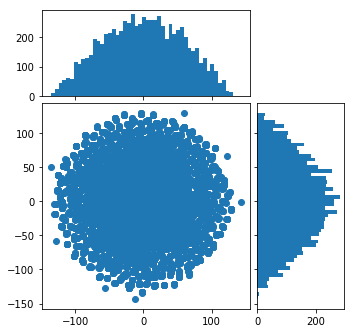

In [105]:
fig, axScatter = plt.subplots(figsize=(5.5, 5.5))

axScatter.scatter(np.array(TSNE_fit_transform_5)[:, 0], np.array(TSNE_fit_transform_5)[:, 1])
axScatter.set_aspect(1.)

divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

xymax = max(np.max(np.abs(np.array(TSNE_fit_transform_5)[:, 0])), \
            np.max(np.abs(np.array(TSNE_fit_transform_5)[:, 1])))
lim = (int(xymax/binwidth) + 1)*binwidth

bins=50
axHistx.hist(np.array(TSNE_fit_transform_5)[:, 0], bins=bins)
axHisty.hist(np.array(TSNE_fit_transform_5)[:, 1], bins=bins, orientation='horizontal')

plt.draw()
plt.show()

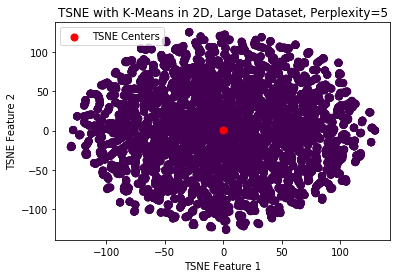

In [108]:
kmeans = sklearn.cluster.KMeans(n_clusters=1).fit(TSNE_fit_transform_ext_5)
cluster_centers = kmeans.cluster_centers_
plt.figure()
plt.scatter(np.array(TSNE_fit_transform_ext_5)[:, 0], np.array(TSNE_fit_transform_ext_5)[:, 1],\
            c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='TSNE Centers')
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
plt.title('TSNE with K-Means in 2D, Large Dataset, Perplexity=5')
plt.legend()
plt.show()


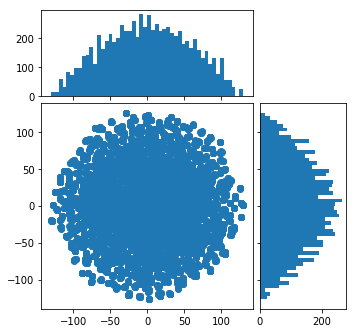

In [101]:
fig, axScatter = plt.subplots(figsize=(5.5, 5.5))

axScatter.scatter(np.array(TSNE_fit_transform_ext_5)[:, 0], np.array(TSNE_fit_transform_ext_5)[:, 1])
axScatter.set_aspect(1.)

divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

xymax = max(np.max(np.abs(np.array(TSNE_fit_transform_ext_5)[:, 0])), \
            np.max(np.abs(np.array(TSNE_fit_transform_ext_5)[:, 1])))
lim = (int(xymax/binwidth) + 1)*binwidth

bins=50
axHistx.hist(np.array(TSNE_fit_transform_ext_5)[:, 0], bins=bins)
axHisty.hist(np.array(TSNE_fit_transform_ext_5)[:, 1], bins=bins, orientation='horizontal')

plt.draw()
plt.show()

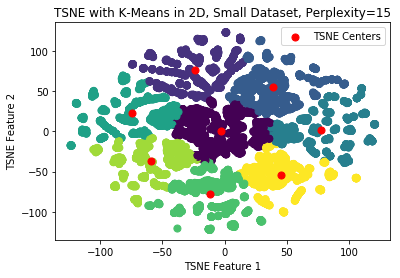

In [109]:
kmeans = sklearn.cluster.KMeans(n_clusters=8).fit(TSNE_fit_transform_15)
cluster_centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(np.array(TSNE_fit_transform_15)[:, 0], np.array(TSNE_fit_transform_15)[:, 1],\
            c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='TSNE Centers')
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
plt.title('TSNE with K-Means in 2D, Small Dataset, Perplexity=15')
plt.legend()
plt.show()


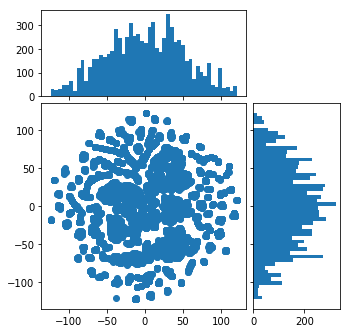

In [102]:
fig, axScatter = plt.subplots(figsize=(5.5, 5.5))

axScatter.scatter(np.array(TSNE_fit_transform_15)[:, 0], np.array(TSNE_fit_transform_15)[:, 1])
axScatter.set_aspect(1.)

divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

xymax = max(np.max(np.abs(np.array(TSNE_fit_transform_15)[:, 0])), \
            np.max(np.abs(np.array(TSNE_fit_transform_15)[:, 1])))
lim = (int(xymax/binwidth) + 1)*binwidth

bins=50
axHistx.hist(np.array(TSNE_fit_transform_15)[:, 0], bins=bins)
axHisty.hist(np.array(TSNE_fit_transform_15)[:, 1], bins=bins, orientation='horizontal')

plt.draw()
plt.show()

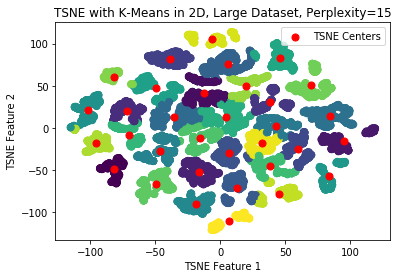

In [147]:
kmeans = sklearn.cluster.KMeans(n_clusters=33).fit(TSNE_fit_transform_ext_15)
cluster_centers = kmeans.cluster_centers_

plt.figure()
plt.scatter(np.array(TSNE_fit_transform_ext_15)[:, 0], np.array(TSNE_fit_transform_ext_15)[:, 1],\
            c=kmeans.labels_, s=50, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=50,label='TSNE Centers')
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
plt.title('TSNE with K-Means in 2D, Large Dataset, Perplexity=15')
plt.legend()
plt.show()


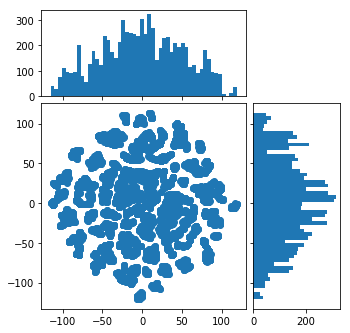

In [103]:
fig, axScatter = plt.subplots(figsize=(5.5, 5.5))

axScatter.scatter(np.array(TSNE_fit_transform_ext_15)[:, 0], np.array(TSNE_fit_transform_ext_15)[:, 1])
axScatter.set_aspect(1.)

divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", 1.2, pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", 1.2, pad=0.1, sharey=axScatter)

axHistx.xaxis.set_tick_params(labelbottom=False)
axHisty.yaxis.set_tick_params(labelleft=False)

xymax = max(np.max(np.abs(np.array(TSNE_fit_transform_ext_15)[:, 0])), \
            np.max(np.abs(np.array(TSNE_fit_transform_ext_15)[:, 1])))
lim = (int(xymax/binwidth) + 1)*binwidth

bins=50
axHistx.hist(np.array(TSNE_fit_transform_ext_15)[:, 0], bins=bins)
axHisty.hist(np.array(TSNE_fit_transform_ext_15)[:, 1], bins=bins, orientation='horizontal')

plt.draw()
plt.show()

### Task 1.7: Neural Network Training Using Dimensionality Reduction Techniques

Neural network, built without dimensionality reduction data...

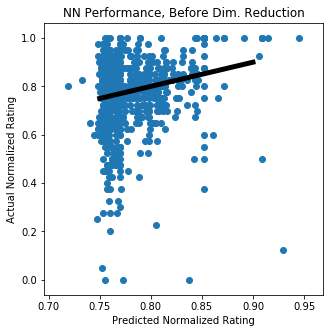

4.126505909662416


In [42]:
features = cluster_data_normalized[['Size','Installs','Reviews','Price']].copy()
targets = cluster_data_normalized['Rating'].copy()
training_features = features[:int(0.9*len(features))]
testing_features = features[int(0.9*len(features)):]

training_target = targets[:int(0.9*len(targets))]
testing_target = targets[int(0.9*len(targets)):]

model = Sequential()
model.add(Dense(4, input_dim=4, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(training_features, training_target, epochs=200, batch_size=200,verbose=0)
final_prediction = model.predict(testing_features)
final_prediction = final_prediction.T.tolist()[0]
plt.figure(figsize=(5,5))
plt.scatter(final_prediction,testing_target)
plt.xlabel('Predicted Normalized Rating')
plt.ylabel('Actual Normalized Rating')
plt.title('NN Performance, Before Dim. Reduction')
plt.plot([0.75,0.9],[0.75,0.9],color='black',linewidth=5)
plt.show()
rmse = np.sqrt(sum([(i-j)**2 for (i,j) in zip(final_prediction,testing_target)]))
print rmse

Neural network, built with dimensionality reduction data...

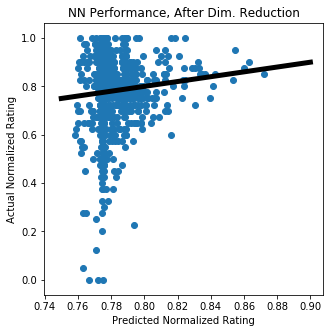

4.140743846810285


In [46]:
features = cluster_data_normalized[['Size','Installs','Reviews','Price']].copy()
features['Clusters']=kmeans_ICA.labels_
targets = cluster_data_normalized['Rating'].copy()
training_features = features[:int(0.9*len(features))]
testing_features = features[int(0.9*len(features)):]

training_target = targets[:int(0.9*len(targets))]
testing_target = targets[int(0.9*len(targets)):]

model = Sequential()
model.add(Dense(4, input_dim=5, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(training_features, training_target, epochs=200, batch_size=200,verbose=0)
final_prediction = model.predict(testing_features)
final_prediction = final_prediction.T.tolist()[0]
plt.figure(figsize=(5,5))
plt.scatter(final_prediction,testing_target)
plt.xlabel('Predicted Normalized Rating')
plt.ylabel('Actual Normalized Rating')
plt.title('NN Performance, After Dim. Reduction')
plt.plot([0.75,0.9],[0.75,0.9],color='black',linewidth=5)
plt.show()
rmse = np.sqrt(sum([(i-j)**2 for (i,j) in zip(final_prediction,testing_target)]))
print rmse

In [51]:
#features = cluster_data_normalized[['Size','Installs','Reviews','Price']].copy()
#features['Clusters']=kmeans_ICA.labels_
features = kmeans_ICA.labels_
targets = cluster_data_normalized['Rating'].copy()
training_features = features[:int(0.9*len(features))]
testing_features = features[int(0.9*len(features)):]

training_target = targets[:int(0.9*len(targets))]
testing_target = targets[int(0.9*len(targets)):]

model = Sequential()
model.add(Dense(4, input_dim=1, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(training_features, training_target, epochs=200, batch_size=200,verbose=0)
final_prediction = model.predict(testing_features)
final_prediction = final_prediction.T.tolist()[0]


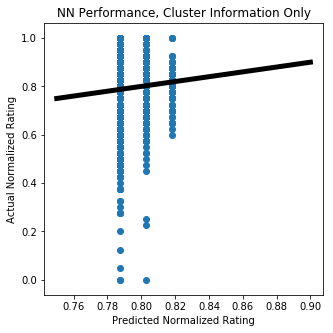

4.208575132038143
0.027222348848888377


In [54]:
plt.figure(figsize=(5,5))
plt.scatter(final_prediction,testing_target)
plt.xlabel('Predicted Normalized Rating')
plt.ylabel('Actual Normalized Rating')
plt.title('NN Performance, Cluster Information Only')
plt.plot([0.75,0.9],[0.75,0.9],color='black',linewidth=5)
plt.show()
rmse = np.sqrt(sum([(i-j)**2 for (i,j) in zip(final_prediction,testing_target)]))
print rmse
print rmse/len(final_prediction)*5